### Finding the best ratio features

The goal of this notebook is to build a multiclass classifier, only with the ratio features and use it to find which ones are the better ones to use. That will in turn be used to reduce the dimensionality of the ratios since these features are 756 in total.

The directory from which the csv files are being parsed is

    'data/Main collection - features/'
    
Ultimately, the goal is to create a csv file for the best euclidean distance ratios and another one for the temporal ratios. The directory where the csvs will be stored is 

    'data/Main collection - features/best ratios by multiclass RF/'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Pretty display for notebooks
%matplotlib inline

random_state = 0

rows_each = 60

# specify the place from where we will use the data
source_path_rel = 'data/Main collection - features/'

# specify the target path for the two feature selections
target_path_rel = source_path_rel + 'best ratios by multiclass RF/'

# find the file names in the directory
feature_files = os.listdir(source_path_rel)

# remove the readme, and the Giorgos files
feature_files.remove('README.md')
feature_files.remove('Giorgos Mon 19.csv')
feature_files.remove('Giorgos Wed 21.csv')
feature_files.remove('Giorgos Fri 23.csv')
feature_files.remove('Giorgos Mon 26.csv')
feature_files.remove('best ratios by multiclass RF')

print("The number of files in the directory is {}".format(len(feature_files))) 

The number of files in the directory is 16


In [2]:
# DEBUGGING OPTIONS
np.set_printoptions(threshold=400)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10)

#### Loading the files and Selecting the ratios

The next step is to load the files, and then drop all other columns except the ratios. We can recognize the ratios because the third character of the feature name is '|', for example, the ratio between sides AB and AC is 'AB|AC_xyz'. That ratio is in terms of their euclidean distance. In the case of temporal distance the ratio should be like 'AB|AC_mil'.

In [3]:
# initialize the two data frames
X_euc = pd.DataFrame()
X_mil = pd.DataFrame()

# create the labels
y = pd.Series([i for i in range(1, len(feature_files)+1) for j in range(rows_each)])

for i, file in enumerate(feature_files):
    
    # read each features file into a df
    df = pd.read_csv(source_path_rel+file)
    
    # select a sample of 60 values (without replacement)
    df = df.sample(n=rows_each, random_state=random_state, axis=0)
    
    # sort the sampled dataframe by index 
    #df.sort_index(inplace=True)
    df.index = range(df.shape[0])
    
    # get the columns of the dataframe
    cols = df.columns.values
    
    # select only the columns with ratios of euclidean distance
    cols_euc = [c for c in cols if c[2]=='|' and c[-3:]=='xyz']# + ['class']
    
    # select only the columns with ratios of temporal distance
    cols_mil = [c for c in cols if c[2]=='|' and c[-3:]=='mil']# + ['class']
    
    # add the data to the bigger dataframe
    X_euc = pd.concat([X_euc, df.loc[:, cols_euc]], ignore_index=True)
    
    # add the data to the bigger dataframe
    X_mil = pd.concat([X_mil, df.loc[:, cols_mil]], ignore_index=True)
    
    #break
    
display(X_euc.head(5))
display(X_mil.head(5))

print("The two dataframes have {} and {} rows, and {} and {} columns respectively."
      .format(X_euc.shape[0], X_mil.shape[0], X_euc.shape[1], X_mil.shape[1]))
print("The labels series consists of {} labels that correspond to the label of each df row."
      .format(y.shape[0]))

,AB|AC_xyz,AB|AD_xyz,AB|AE_xyz,AB|AF_xyz,AB|AG_xyz,...,EH|FH_xyz,EH|GH_xyz,FG|FH_xyz,FG|GH_xyz,FH|GH_xyz
0,0.655369,0.456014,0.494882,0.789255,0.812789,...,1.530549,1.631943,0.962667,1.026440,1.066247
1,0.629426,0.472538,0.526191,0.787613,0.867094,...,1.412418,1.697681,0.968461,1.164059,1.201968
2,0.757873,0.532349,0.587626,1.003578,0.963419,...,1.586711,1.665524,1.087622,1.141645,1.049670
3,0.689733,0.499247,0.520312,0.741974,0.766395,...,1.389911,1.442968,1.026840,1.066037,1.038172
4,0.701026,0.476241,0.504194,0.686200,0.767871,...,1.352195,1.510472,1.000939,1.118100,1.117052


,AB|AC_mil,AB|AD_mil,AB|AE_mil,AB|AF_mil,AB|AG_mil,...,EH|FH_mil,EH|GH_mil,FG|FH_mil,FG|GH_mil,FH|GH_mil
0,0.418919,0.332822,0.289141,0.232458,0.180608,...,1.228464,1.846154,0.334582,0.502814,1.502814
1,0.548035,0.436522,0.371577,0.316320,0.244401,...,1.107224,1.405421,0.212176,0.269319,1.269319
2,0.549325,0.437552,0.366597,0.298196,0.232630,...,1.207134,1.756831,0.312891,0.455373,1.455373
3,0.558269,0.455204,0.394819,0.325566,0.249752,...,1.129727,1.456790,0.224509,0.289506,1.289506
4,0.447964,0.330735,0.262367,0.217423,0.156563,...,1.164211,1.855705,0.372632,0.593960,1.593960


The two dataframes have 960 and 960 rows, and 378 and 378 columns respectively.
The labels series consists of 960 labels that correspond to the label of each df row.


***

### Euclidean Distances

In the beginning we will try to find the best features in terms of the euclidean ratios. In order to do that we will, split our euclidean distance data, then build a Random Forest Classifier and see which features were the best for splitting in the trees. In order to see how robust these results are, we will see if by changing some parameters the best features also change. Finally, we will also test the accuracy of the model to get an indication of the performance.

#### Split off the Dataset

In order to do the classification and find the feature importances, we will first split the dataset into train and test split. It is also important to keep the categories in tact, in the sense that all classes should be represented equally in the train and test samples. In order to do that we will use 25% of the dataset for testing which accounts for 15 testing samples per category.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [5]:
# make a train test split
X_train_euc, X_test_euc, y_train_euc, y_test_euc = train_test_split(X_euc, y, 
                                                                    test_size=0.25, 
                                                                    random_state=random_state, 
                                                                    stratify=y)

print("The value counts for each label are:\n{}".format(y_test_euc.value_counts().sort_index()))

The value counts for each label are:
1     15
2     15
3     15
4     15
5     15
6     15
7     15
8     15
9     15
10    15
11    15
12    15
13    15
14    15
15    15
16    15
dtype: int64


#### Build Classifiers

The classifiers that will be checked are all RFs with a grid search at the following parameters:

    'n_estimators=[4000, 6000]' 
    'criterion=['gini', 'entropy']'
    'min_leaf=[1, 3, 5, 7, 9]'

In [6]:
params = []

estimators = [4000, 6000]
criteria = ['gini', 'entropy']
min_leaf = [1, 3, 5, 7, 9]

for e in estimators:
    for c in criteria:
        for l in min_leaf:
            params.append([e, c, l])

In [7]:
def updateAllFeatures(all_features, indices, importances, cols):
    """ Updates the features data structure that holds all importance scores across all 
    classifiers. """
    
    for ind in indices:
        
        # find the features name (e.g. 'CD|DF_xyz')
        f = cols[ind]
        
        # update the data structure
        all_features[f].append(importances[ind])
        

def updateTopFeatures(top_features, indices, cols, importances):
    """ Updates the features data structure that holds the importance scores and counts 
    of only the best features. """
    
    for ind in indices:
        
        # find the features name (e.g. 'CD|DF_xyz')
        f = cols[ind]
        
        if f in top_features:
            
            # increment the counter
            top_features[f].append(importances[ind])

        else:
            
            # initialize the feature in the data structure
            top_features[f] = [importances[ind]]
            

def findMeanImportances(clf, top_features, all_features, cols, num_features=30):
    """ Finds the importances and adds it to features dictionary along with the mean importances 
    with the help of updateFeatures function """

    # get the importance scores for all features
    importances = clf.feature_importances_
    # get the std of each features importance across all estimators
    #stds = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    # find the indices for the 
    indices = np.argsort(importances)[::-1]
    # update the counts and means for best features
    updateTopFeatures(top_features, indices[:num_features], cols, importances)
    # add the importance score to the data structure that keeps the scores
    updateAllFeatures(all_features, indices, importances, cols)

In [8]:
top_features_euc = {}

all_features_euc = {col: [] for col in cols_euc}

best_params = []

for e, c, l in params:

    # initialize the classifier
    clf = RandomForestClassifier(n_estimators=e, 
                                 criterion=c, 
                                 min_samples_leaf=l, 
                                 n_jobs=-1, 
                                 random_state=random_state)

    # fit the classifier
    clf.fit(X_train_euc, y_train_euc)

    # predict
    y_pred = clf.predict(X_test_euc)
    y_pred_train = clf.predict(X_train_euc)
    
    # calculate the mean importances
    findMeanImportances(clf, top_features_euc, all_features_euc, cols_euc, num_features=30)

    print("The accuracy on the prediction is {:.4f}, and on the train set {:.4f}."
          .format(accuracy_score(y_test_euc, y_pred), accuracy_score(y_train_euc, y_pred_train)))
    print("--> the parameters were: {} estimators, {} criterion and {} min samples leaf.\n"
          .format(e, c, l))

The accuracy on the prediction is 0.8667, and on the train set 1.0000.
--> the parameters were: 4000 estimators, gini criterion and 1 min samples leaf.

The accuracy on the prediction is 0.8583, and on the train set 0.9986.
--> the parameters were: 4000 estimators, gini criterion and 3 min samples leaf.

The accuracy on the prediction is 0.8500, and on the train set 0.9931.
--> the parameters were: 4000 estimators, gini criterion and 5 min samples leaf.

The accuracy on the prediction is 0.8542, and on the train set 0.9819.
--> the parameters were: 4000 estimators, gini criterion and 7 min samples leaf.

The accuracy on the prediction is 0.8458, and on the train set 0.9750.
--> the parameters were: 4000 estimators, gini criterion and 9 min samples leaf.

The accuracy on the prediction is 0.8542, and on the train set 1.0000.
--> the parameters were: 4000 estimators, entropy criterion and 1 min samples leaf.

The accuracy on the prediction is 0.8542, and on the train set 0.9986.
--> the 

In [9]:
def makeDfTopFeatures(features_dict):
    """ Makes the dataframe data structure that will be used for the close look plot. """

    ids, appearances, means, stds = [], [], [], []

    for k, v in features_dict.items():
        ids.append(k)
        appearances.append(len(v))
        means.append(np.mean(v))
        stds.append(np.std(v))

    df_top_euc = pd.DataFrame({'feature id': ids,
                               'appearances': appearances,
                               'mean score': means,
                               'score std': stds},
                              index=range(len(ids)))

    # sort the dataframe according to the mean score
    df_top_euc.sort_values('mean score', ascending=False, inplace=True)
    
    # reset the index
    df_top_euc.index = range(df_top_euc.shape[0])
    
    return df_top_euc

# call the above function to make the dataframe
df_top_euc = makeDfTopFeatures(top_features_euc)
# show the dataframe
display(df_top_euc.head(5))

,feature id,appearances,mean score,score std
0,AG|CE_xyz,20,0.016705,0.005377
1,CE|DF_xyz,20,0.014994,0.002422
2,AE|CE_xyz,12,0.012796,0.003434
3,EG|FG_xyz,10,0.011787,0.000964
4,DG|EH_xyz,20,0.011716,0.002264


In [10]:
def makeDfAllFeatures(features_dict):
    """ Makes the dataframe data structure that will be used for the distant look plot. """

    ids, means = [], []

    for k, v in features_dict.items():
        ids.append(k)
        means.append(np.mean(v))

    df_all_euc = pd.DataFrame({'feature id': ids,
                               'mean score': means},
                              index=range(len(ids)))

    # sort the dataframe according to the mean score
    df_all_euc.sort_values('mean score', ascending=False, inplace=True)
    
    # reset the index
    df_all_euc.index = range(df_all_euc.shape[0])
    
    return df_all_euc

# call the above function to make the dataframe
df_all_euc = makeDfAllFeatures(all_features_euc)
# show the dataframe
display(df_all_euc.head(5))

,feature id,mean score
0,AG|CE_xyz,0.016705
1,CE|DF_xyz,0.014994
2,DG|EH_xyz,0.011716
3,AG|FG_xyz,0.010769
4,CE|GH_xyz,0.010228


#### Visualize and drop features as csv

The last step is to make a visualization for the features and their accuracy and copy the feature names from the index to a column and save the features in a csv.

In [11]:
# style
plt.style.use('bmh')

#def plotTopImportances(importances, stds, indices, col_names, img_name, n=20, save_fig=False):
def plotTopImportances(scores, names, stds, img_name, n=20, save_fig=False):
    """ Plots the importances of the features in two plots. The first plot refers to all 
    the features in the dataset, and the second to the best 20 features that will also be
    used in the classification. """
    
    # init the figure and the axes object
    fig, ax = plt.subplots(1, 1)
    fig.set_tight_layout(False)

    # adjust the size of the figure
    fig.set_figwidth(12)
    fig.set_figheight(6)
    
    # plot
    ax.bar(names[:n], scores[:n], color="r", yerr=stds[:n], align="center")
    # set text axes 1
    ax.set_title('Features Importances (top {} features)'.format(n)) if not save_fig else None
    ax.set_xlabel('Feature names')
    ax.set_ylabel('Importance')
    # get the labels to rotate them
    labels = ax.get_xticklabels()
    # rotate
    plt.setp(labels, rotation=45, horizontalalignment='right')
    
    # save or show
    fig.savefig('images/'+img_name+'.png', bbox_inches='tight') if save_fig else plt.show()
    # close the image
    plt.close()

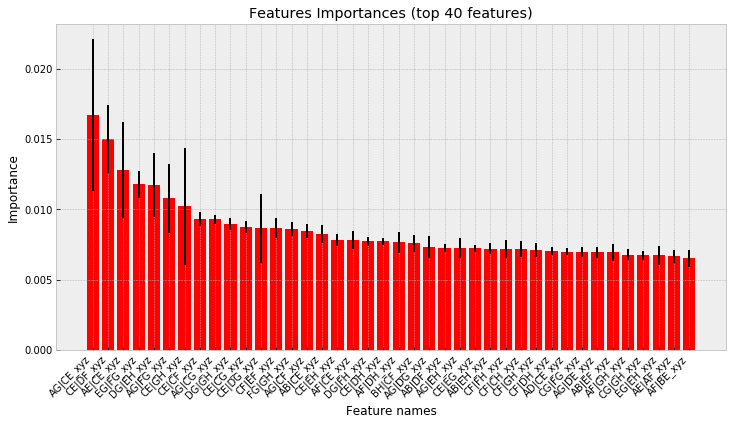

In [12]:
# display the best features image
plotTopImportances(df_top_euc['mean score'], df_top_euc['feature id'], df_top_euc['score std'], 
                   'Top 20 euclidean', n=40, save_fig=False)
plotTopImportances(df_top_euc['mean score'], df_top_euc['feature id'], df_top_euc['score std'], 
                   'Top 20 euclidean', n=40, save_fig=True)

In [13]:
# style
plt.style.use('bmh')

def plotAllImportances(scores, img_name, save_fig=False):
    """ Plots the importances of the features in two plots. The first plot refers to all 
    the features in the dataset, and the second to the best 20 features that will also be
    used in the classification. """
    
    # init the figure and the axes object
    fig, ax = plt.subplots(1, 1)
    fig.set_tight_layout(False)

    # adjust the size of the figure
    fig.set_figwidth(12)
    fig.set_figheight(6)
    
    # plot
    #ax.bar(names[:n], scores[:n], color="r", yerr=stds[:n], align="center")
    ax.bar(range(len(scores)), scores, color="r", align="center")
    # set text axes 1
    ax.set_title('Features Importances (all features)') if not save_fig else None
    ax.set_xlabel('Features')
    ax.set_ylabel('Importance')
    # get the labels to rotate them
    labels = ax.get_xticklabels()
    # rotate
    plt.setp(labels, rotation=45, horizontalalignment='right')
    
    # save or show
    fig.savefig('images/'+img_name+'.png', bbox_inches='tight') if save_fig else plt.show()
    # close the image
    plt.close()

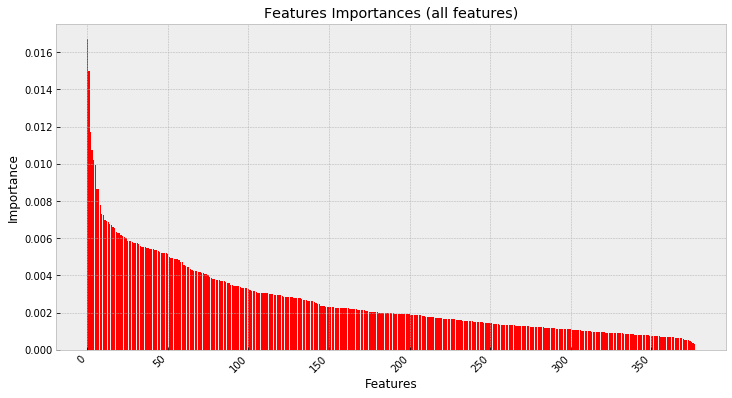

In [14]:
# display the image that includes all features
plotAllImportances(df_all_euc['mean score'], 'All euclidean', save_fig=False)
plotAllImportances(df_all_euc['mean score'], 'All euclidean', save_fig=True)

In [15]:
# save to csv
df_top_euc.to_csv(target_path_rel + 'Euclidean distance ratios.csv', index=False)

***

### Temporal Distances

The same process will be followed in regards to the temporal distances.

#### Split off the Dataset

In [16]:
# make a train test split
X_train_mil, X_test_mil, y_train_mil, y_test_mil = train_test_split(X_mil, y, 
                                                                    test_size=0.25, 
                                                                    random_state=random_state, 
                                                                    stratify=y)

print("The value counts for each label are:\n{}".format(y_test_mil.value_counts().sort_index()))

The value counts for each label are:
1     15
2     15
3     15
4     15
5     15
6     15
7     15
8     15
9     15
10    15
11    15
12    15
13    15
14    15
15    15
16    15
dtype: int64


#### Build the Datasets

In [17]:
top_features_mil = {}

all_features_mil = {col: [] for col in cols_mil}

best_params = []

for e, c, l in params:

    # initialize the classifier
    clf = RandomForestClassifier(n_estimators=e, 
                                 criterion=c, 
                                 min_samples_leaf=l, 
                                 n_jobs=-1, 
                                 random_state=random_state)

    # fit the classifier
    clf.fit(X_train_mil, y_train_mil)

    # predict
    y_pred = clf.predict(X_test_mil)
    y_pred_train = clf.predict(X_train_mil)
    
    # calculate the mean importances
    findMeanImportances(clf, top_features_mil, all_features_mil, cols_mil, num_features=30)

    print("The accuracy on the prediction is {:.4f}, and on the train set {:.4f}."
          .format(accuracy_score(y_test_mil, y_pred), accuracy_score(y_train_mil, y_pred_train)))
    print("--> the parameters were: {} estimators, {} criterion and {} min samples leaf.\n"
          .format(e, c, l))

The accuracy on the prediction is 0.4583, and on the train set 1.0000.
--> the parameters were: 4000 estimators, gini criterion and 1 min samples leaf.

The accuracy on the prediction is 0.4583, and on the train set 0.9681.
--> the parameters were: 4000 estimators, gini criterion and 3 min samples leaf.

The accuracy on the prediction is 0.4667, and on the train set 0.8903.
--> the parameters were: 4000 estimators, gini criterion and 5 min samples leaf.

The accuracy on the prediction is 0.4667, and on the train set 0.8083.
--> the parameters were: 4000 estimators, gini criterion and 7 min samples leaf.

The accuracy on the prediction is 0.4708, and on the train set 0.7458.
--> the parameters were: 4000 estimators, gini criterion and 9 min samples leaf.

The accuracy on the prediction is 0.4625, and on the train set 1.0000.
--> the parameters were: 4000 estimators, entropy criterion and 1 min samples leaf.

The accuracy on the prediction is 0.4625, and on the train set 0.9764.
--> the 

In [18]:
# call the function defined earlier to make the dataframe
df_top_mil = makeDfTopFeatures(top_features_mil)
# show the dataframe
display(df_top_mil.head(5))

,feature id,appearances,mean score,score std
0,AG|BE_mil,20,0.008352,0.002793
1,BE|EG_mil,20,0.007312,0.001943
2,BG|DG_mil,10,0.007261,0.001129
3,BE|BG_mil,20,0.007222,0.001864
4,BD|DG_mil,10,0.007190,0.001070


In [19]:
# call the function defined earlier to make the dataframe
df_all_mil = makeDfAllFeatures(all_features_mil)
# show the dataframe
display(df_all_mil.head(5))

,feature id,mean score
0,AG|BE_mil,0.008352
1,BE|EG_mil,0.007312
2,BE|BG_mil,0.007222
3,BG|EG_mil,0.007165
4,BE|DG_mil,0.006172


#### Visualize and drop features as csv

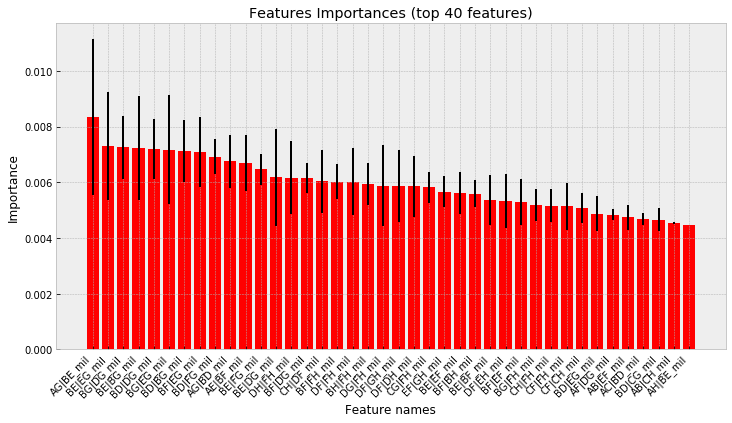

In [20]:
# display the best features image
plotTopImportances(df_top_mil['mean score'], df_top_mil['feature id'], df_top_mil['score std'], 
                   'Top 20 temporal', n=40, save_fig=False)
plotTopImportances(df_top_mil['mean score'], df_top_mil['feature id'], df_top_mil['score std'], 
                   'Top 20 temporal', n=40, save_fig=True)

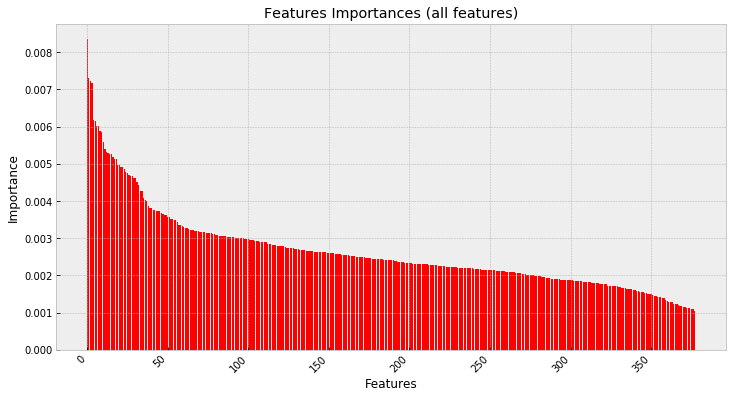

In [21]:
# display the image that includes all features
plotAllImportances(df_all_mil['mean score'], 'All temporal', save_fig=False)
plotAllImportances(df_all_mil['mean score'], 'All temporal', save_fig=True)

In [22]:
# save to csv
df_top_mil.to_csv(target_path_rel + 'Temporal distance ratios.csv', index=False)